In [1]:
import pandas as pd
import datetime
import stock_data as stock
import numpy as np
from tqdm import tqdm

### Get Data

In [2]:
import stock_data as stock

scrapy = stock.Scrapy()
today = datetime.datetime.today()
end = f"{today.year}-12-31"

price = scrapy.get_price(
    start = "2013-01-01",
    end = end,
    mode = "listed"
)
price.to_csv("data/price_2013_2023.csv", index = False)
print(f"length = {len(price)}")
price.head()

twiis = scrapy.get_price(
    start = "2013-01-01",
    end = end,
    mode = "other",
    query = "^TWII"
)
twiis.to_csv("data/twii_2013_2023.csv", index = False)

ratio = scrapy.get_financial_statement(
    type_ = 3,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911
)
ratio.to_csv("data/ratio_2013_2023.csv", index = False)
print(f"length = {len(ratio)}")
ratio.head()

income = scrapy.get_financial_statement(
    type_ = 1,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911
)
income.to_csv("data/income_2013_2023.csv", index = False)
print(f"length = {len(income)}")
income.head()

asset = scrapy.get_financial_statement(
    type_ = 2,
    clean = 1, 
    mode = "listed",
    start_year = today.year-1911-10, 
    end_year = today.year-1911
)
asset.to_csv("data/asset_2013_2023.csv", index = False)
print(f"length = {len(asset)}")
asset.head()

### Load Data

In [3]:
twii_raw = pd.read_csv("data/twii_2013_2023.csv", parse_dates = ["Date"])
price_raw = pd.read_csv("data/price_2013_2023.csv", parse_dates = ["Date"])
ratio_raw = pd.read_csv("data/ratio_2013_2023.csv")
income_raw = pd.read_csv("data/income_2013_2023.csv")
asset_raw = pd.read_csv("data/asset_2013_2023.csv")
print(f"twii_raw length = {len(twii_raw)}")
print(f"price length = {len(price_raw)}")
print(f"ratio length = {len(ratio_raw)}")
print(f"income_raw length = {len(income_raw)}")
print(f"asset_raw length = {len(asset_raw)}")

twii_raw length = 2652
price length = 2422429
ratio length = 38100
income_raw length = 39387
asset_raw length = 39387


#### Clean

In [4]:
def price(df):
    df = df.drop(["Open", "High", "Low", "Close"], axis = 1)
    df = df.rename(columns = {"Adj Close": "Close"})
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    return df

In [5]:
twii_raw = price(twii_raw)
twii_raw.head(3)

,Symbol,Date,Close,Volume,Year,Month,Day
0,^TWII,2013-01-02,7779.19,2194600,2013,1,2
1,^TWII,2013-01-03,7836.81,2964400,2013,1,3
2,^TWII,2013-01-04,7805.96,2696800,2013,1,4


In [6]:
price_raw["Symbol"] = price_raw["Symbol"].str.split(".").str[0]
price_raw = price_raw.sort_values(["Symbol", "Date"]).reset_index(drop = True)
price_raw = price(price_raw)
price_raw.head(3)

,Symbol,Date,Close,Volume,Year,Month,Day
0,1101,2013-01-02,16.79,8646455.0,2013,1,2
1,1101,2013-01-03,16.73,13179046.0,2013,1,3
2,1101,2013-01-04,16.79,11763801.0,2013,1,4


In [7]:
def statement(df, keep_col, new_col_name):
    df = df.iloc[:, keep_col]
    df.columns = new_col_name
    df = df.sort_values(["Symbol", "Year", "Season"]).reset_index(drop = True)
    df["Symbol"] = df["Symbol"].astype(str)
    df["Year"] = df["Year"] + 1911

    return df

In [8]:
ratio_raw = statement(ratio_raw, keep_col = [0,1,2,3,4,5,6,8], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Sales", "Gross", "Operating", "Net"])
ratio_raw.head(3)

,Year,Season,Symbol,Name,Sales,Gross,Operating,Net
0,2013,1,1101,台泥,24114.05,12.95,8.40,8.29
1,2013,2,1101,台泥,52784.23,16.57,12.53,10.99
2,2013,3,1101,台泥,82891.07,19.06,15.11,13.45


In [9]:
income_raw = statement(income_raw, keep_col = [0,1,2,3,4,5,6,8,10], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Sales", "Gross", "Operating", "Net", "EPS"])
income_raw.head(3)

,Year,Season,Symbol,Name,Sales,Gross,Operating,Net,EPS
0,2013,1,1101,台泥,24114047.0,3123872.0,2026729.0,1999624.0,0.38
1,2013,2,1101,台泥,52784231.0,8745881.0,6615721.0,5801729.0,1.08
2,2013,3,1101,台泥,82891070.0,15800370.0,12526355.0,11146391.0,2.06


In [10]:
asset_raw = statement(asset_raw, keep_col = [0,1,2,3,6,14], new_col_name = ['Year', 'Season', 'Symbol', 'Name', "Asset", "Equity"])
asset_raw.head(3)

,Year,Season,Symbol,Name,Asset,Equity
0,2013,1,1101,台泥,272835233.0,145365698.0
1,2013,2,1101,台泥,273644455.0,139207168.0
2,2013,3,1101,台泥,271992941.0,145196356.0


### Imputer time

In [11]:
def imputer_time(df, name):
    df1 = pd.DataFrame()
    g = df.groupby("Symbol")
    combinations = df[["Year", "Season"]].drop_duplicates(ignore_index = True)
    for group, df_group in tqdm(g, desc = name):
        df_group = pd.merge(combinations, df_group, on = ["Year", "Season"], how = "left")
        df_group[["Symbol", "Name"]] = df_group[["Symbol", "Name"]].fillna(method = "ffill").fillna(method = "bfill")    
        df1 = pd.concat([df1, df_group], ignore_index = True)

    return df1

In [12]:
ratio_raw  = imputer_time(df = ratio_raw,  name = "ratio")
income_raw = imputer_time(df = income_raw, name = "income")
asset_raw  = imputer_time(df = asset_raw,  name = "asset")

print(f"ratio_raw length = {len(ratio_raw)}")
print(f"income_raw length = {len(income_raw)}")
print(f"asset_raw length = {len(asset_raw)}")

ratio:   0%|          | 0/964 [00:00<?, ?it/s]

asset: 100%|██████████| 990/990 [00:02<00:00, 420.28it/s]

ratio_raw length = 41452
income_raw length = 42570
asset_raw length = 42570


### Remove cumulative

In [13]:
def remove_cumulative(df, name, col):
    g1 = df.groupby("Symbol")
    df_symbol = pd.DataFrame()
    for group1, df_group1 in tqdm(g1, desc = name):
        g2 = df_group1.groupby("Year")
        df_year = pd.DataFrame()
        
        for group2, df_group2 in g2:
            df_group2 = df_group2.reset_index(drop = True)
            df_group2_1 = df_group2[col] - df_group2[col].shift(1)
            df_group2_1.loc[0] = df_group2.loc[0, col]
            df_group2[col] = df_group2_1
            df_year = pd.concat([df_year, df_group2], ignore_index = True)

        df_symbol = pd.concat([df_symbol, df_year], ignore_index = True)

    df_symbol = df_symbol.sort_values(["Symbol", "Year", "Season"]).reset_index(drop = True)
    
    return df_symbol

In [14]:
# ratio_raw  = remove_cumulative(df = ratio_raw,  name = "ratio",  col = ['Sales'])
income_raw1 = remove_cumulative(df = income_raw, name = "income", col = ['Sales', 'Gross', 'Operating', 'Net', 'EPS'])

income:   0%|          | 0/990 [00:00<?, ?it/s]

income: 100%|██████████| 990/990 [00:25<00:00, 39.25it/s]


### Split year & Season

In [15]:
def split_year(df, name, group_cols):
    dfs = {}
    g = df.groupby(group_cols)
    for group, df_group in tqdm(g, desc = name):
        df_group = df_group.reset_index(drop = True)
        dfs[group] = df_group
    
    return dfs

In [16]:
prices  = split_year(df = price_raw,   name = "price",  group_cols = "Year")
twiis   = split_year(df = twii_raw,    name = "twii",   group_cols = "Year")
ratios  = split_year(df = ratio_raw,   name = "ratio",  group_cols = ["Year", "Season"])
incomes = split_year(df = income_raw1, name = "income", group_cols = ["Year", "Season"])
assets  = split_year(df = asset_raw,   name = "asset",  group_cols = ["Year", "Season"])

asset: 100%|██████████| 43/43 [00:00<00:00, 3307.02it/s]


### Filter stock by ratio

In [17]:
filter_stock = []
all_seasons = list(ratios.keys())

# 加上最後的預測項
if all_seasons[-1][1] == 4:
    all_seasons.append(tuple((all_seasons[-1][0] + 1, 1)))
else:
    all_seasons.append(tuple((all_seasons[-1][0], all_seasons[-1][1] + 1)))

for i in tqdm(range(len(all_seasons)-8)):
    # 抓出近8季資料
    ratio = pd.DataFrame()
    for year_season in all_seasons[i:i+8]:
        ratio = pd.concat([ratio, ratios[year_season]], ignore_index = True)

    # 營收YOY為正，且三率三升
    ratio1 = pd.DataFrame()
    g = ratio.groupby("Symbol")
    for group, df_group in g:
        df_group = df_group.reset_index(drop = True)
        
        # 近8季 營收、毛利率、營業利益率、稅後淨利率 > 0
        remove_flag = (df_group.loc[:, "Sales":"Net"] < 0).any().any()
        if remove_flag:
            continue
        
        # 近四季 營收YOY > 0、三率三升 (近四季 比 近八到五季 高)
        keep_flag = (df_group.loc[:3, "Sales":"Net"].values < df_group.loc[4:, "Sales":"Net"].values).all()
        if keep_flag:
            df_group = df_group.loc[4:].reset_index(drop = True)
            ratio1 = pd.concat([ratio1, df_group], ignore_index = True)

    portfolio = ratio1["Symbol"].unique()
    filter_stock.append([all_seasons[i+8], f"{all_seasons[i]} ~ {all_seasons[i+7]}", len(portfolio), portfolio])
    
filter_stock = pd.DataFrame(filter_stock, columns = ["Year_Season", "history", "Port_Count", "Portfolio"])
filter_stock

100%|██████████| 36/36 [00:20<00:00,  1.73it/s]


,Year_Season,history,Port_Count,Portfolio
0,"(2015, 1)","(2013, 1) ~ (2014, 4)",89,"[1101, 1102, 1108, 1307, 1338, 1339, 1434, 147..."
1,"(2015, 2)","(2013, 2) ~ (2015, 1)",39,"[1108, 1307, 1338, 1460, 1477, 1536, 1582, 170..."
2,"(2015, 3)","(2013, 3) ~ (2015, 2)",23,"[1108, 1227, 1460, 1477, 1536, 1702, 1708, 220..."
3,"(2015, 4)","(2013, 4) ~ (2015, 3)",26,"[1108, 1227, 1460, 1477, 1536, 1539, 1702, 170..."
4,"(2016, 1)","(2014, 1) ~ (2015, 4)",38,"[1213, 1227, 1460, 1477, 1536, 1539, 1702, 181..."
5,"(2016, 2)","(2014, 2) ~ (2016, 1)",18,"[1460, 1536, 1539, 1817, 2488, 2492, 3023, 350..."
6,"(2016, 3)","(2014, 3) ~ (2016, 2)",24,"[1307, 1460, 1536, 1539, 1541, 1568, 1752, 181..."
7,"(2016, 4)","(2014, 4) ~ (2016, 3)",24,"[1319, 1460, 1568, 1752, 2228, 2345, 2355, 240..."
8,"(2017, 1)","(2015, 1) ~ (2016, 4)",55,"[1215, 1231, 1310, 1319, 1451, 1460, 1522, 156..."
9,"(2017, 2)","(2015, 2) ~ (2017, 1)",17,"[1215, 2236, 2421, 2428, 2439, 2912, 3044, 309..."


### Filter stock by income

In [18]:
filter_stock1 = []
for i in tqdm(range(len(all_seasons)-8)):
    # 抓出近8季資料
    income = pd.DataFrame()
    for year_season in all_seasons[i:i+8]:
        income = pd.concat([income, incomes[year_season]], ignore_index = True)

    # 抓出要進一步篩選的股票
    portfolio = filter_stock.loc[i, "Portfolio"]
    income = income.query("Symbol in @portfolio").reset_index(drop = True)

    # YOY皆為正
    income1 = pd.DataFrame()
    g = income.groupby("Symbol")
    for group, df_group in g:
        df_group = df_group.reset_index(drop = True)

        # 近8季 營收、毛利、營業利益、稅後淨利、EPS > 0
        remove_flag = (df_group.loc[:, "Sales":"EPS"] < 0).any().any()
        if remove_flag:
            continue

        # 所有值 近四季 比 近八到五季 高
        keep_flag = (df_group.loc[:3, "Sales":"EPS"].values < df_group.loc[4:, "Sales":"EPS"].values).all()
        if keep_flag:
            df_group = df_group.loc[4:].reset_index(drop = True)
            income1 = pd.concat([income1, df_group], ignore_index = True)

    portfolio = income1["Symbol"].unique()
    filter_stock1.append([all_seasons[i+8], f"{all_seasons[i]} ~ {all_seasons[i+7]}", len(portfolio), portfolio])
    
filter_stock = pd.DataFrame(filter_stock1, columns = ["Year_Season", "history", "Port_Count", "Portfolio"])
filter_stock

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:01<00:00, 29.24it/s]


,Year_Season,history,Port_Count,Portfolio
0,"(2015, 1)","(2013, 1) ~ (2014, 4)",33,"[1108, 1339, 1477, 1526, 1536, 1589, 1713, 173..."
1,"(2015, 2)","(2013, 2) ~ (2015, 1)",20,"[1108, 1460, 1477, 1536, 1582, 2231, 2330, 234..."
2,"(2015, 3)","(2013, 3) ~ (2015, 2)",12,"[1108, 1477, 1536, 1708, 2231, 2330, 2383, 263..."
3,"(2015, 4)","(2013, 4) ~ (2015, 3)",13,"[1477, 1536, 1708, 2231, 2317, 2383, 2464, 411..."
4,"(2016, 1)","(2014, 1) ~ (2015, 4)",14,"[1477, 1536, 1817, 2108, 2313, 2464, 2608, 411..."
5,"(2016, 2)","(2014, 2) ~ (2016, 1)",9,"[1536, 1817, 2488, 2492, 4119, 4426, 6409, 992..."
6,"(2016, 3)","(2014, 3) ~ (2016, 2)",12,"[1536, 1568, 1752, 1817, 2345, 2488, 2492, 623..."
7,"(2016, 4)","(2014, 4) ~ (2016, 3)",8,"[1319, 2345, 2488, 2492, 4755, 6239, 8341, 9938]"
8,"(2017, 1)","(2015, 1) ~ (2016, 4)",16,"[1215, 1319, 2345, 2415, 2421, 2488, 2492, 291..."
9,"(2017, 2)","(2015, 2) ~ (2017, 1)",11,"[1215, 2421, 2428, 2439, 2912, 3665, 4551, 473..."


### Filter stock by ROE

In [19]:
def generate_roe_data(start, portfolio, current = True):
    periods = all_seasons[start+4:start+8] if current else all_seasons[start:start+4] # 今年該季、去年該季
    # periods = all_seasons[start+4:start+8] if current else all_seasons[start+3:start+7] # 該季、上季
    
    # 抓出近4季income資料
    income = pd.DataFrame()
    for year_season in periods:
        income = pd.concat([income, incomes[year_season]], ignore_index = True)

    # 抓出要進一步篩選的income股票
    portfolio = filter_stock.loc[i, "Portfolio"]
    income = income.query(f"Symbol in @portfolio").reset_index(drop = True)

    # 近4季income累計加總
    income_cols = ["Sales", "Gross", "Operating", "Net", "EPS"]
    income[income_cols] = income.groupby("Symbol")[income_cols].transform("sum")
    income = income.query(f"(Year == {periods[-1][0]}) & (Season == {periods[-1][1]})").reset_index(drop = True)

    # 合併asset和income
    asset = assets[periods[-1]]
    asset = pd.merge(asset, income, on = ["Year", "Season", "Symbol", "Name"])

    # 計算淨利率、資產周轉率、權益乘數、ROE
    asset["Net_ratio"] = asset["Net"] / asset["Sales"]
    asset["asset_turnover_ratio"] = asset["Sales"] / asset["Asset"]
    asset["Equity_Multiplier"] = asset["Asset"] / asset["Equity"]
    asset["ROE"] = asset["Net"] / asset["Equity"]

    return asset

In [20]:
filter_stock1 = []
for i in tqdm(range(0, len(all_seasons)-8)):
    portfolio = filter_stock.loc[i, "Portfolio"]
    asset_current = generate_roe_data(start = i, portfolio = portfolio, current = True) # 該季roe資料
    asset_last = generate_roe_data(start = i, portfolio = portfolio, current = False) # 上季roe資料

    # 今年淨利率、資產周轉率、ROE > 去年淨利率、資產周轉率、ROE
    up_cols = ["Net_ratio", "asset_turnover_ratio", "ROE"]
    keep_up_flag = (asset_current[up_cols] >= asset_last[up_cols]).all(axis = 1)

    # 今年權益乘數 < 去年權益乘數
    keep_down_flag = (asset_current["Equity_Multiplier"] <= asset_last["Equity_Multiplier"])
    keep_flag = keep_up_flag & keep_down_flag

    asset = asset_current[keep_flag].reset_index(drop = True)

    if len(asset) != 0:
        portfolio = asset["Symbol"].unique()
        filter_stock1.append([all_seasons[i+8], f"{all_seasons[i]} ~ {all_seasons[i+7]}", len(portfolio), portfolio])
    
filter_stock = pd.DataFrame(filter_stock1, columns = ["Year_Season", "history", "Port_Count", "Portfolio"])
filter_stock

100%|██████████| 36/36 [00:00<00:00, 59.49it/s]


,Year_Season,history,Port_Count,Portfolio
0,"(2015, 1)","(2013, 1) ~ (2014, 4)",13,"[1108, 1339, 1526, 1536, 2231, 2327, 2330, 248..."
1,"(2015, 2)","(2013, 2) ~ (2015, 1)",13,"[1108, 1460, 2231, 2330, 2383, 2449, 2484, 303..."
2,"(2015, 3)","(2013, 3) ~ (2015, 2)",6,"[1108, 1708, 2231, 2330, 2383, 4119]"
3,"(2015, 4)","(2013, 4) ~ (2015, 3)",5,"[1708, 2317, 2383, 4119, 4426]"
4,"(2016, 1)","(2014, 1) ~ (2015, 4)",7,"[2108, 2608, 4119, 4426, 4938, 6409, 9924]"
5,"(2016, 2)","(2014, 2) ~ (2016, 1)",2,"[4119, 9924]"
6,"(2016, 3)","(2014, 3) ~ (2016, 2)",4,"[1752, 2345, 6239, 8341]"
7,"(2016, 4)","(2014, 4) ~ (2016, 3)",5,"[1319, 2345, 4755, 8341, 9938]"
8,"(2017, 1)","(2015, 1) ~ (2016, 4)",5,"[1319, 2415, 4755, 8016, 9938]"
9,"(2017, 2)","(2015, 2) ~ (2017, 1)",5,"[2439, 2912, 3665, 4755, 8112]"


### Caculate return

In [21]:
def get_price_data(year, season, price_raw, mode = "year"):
    if mode == "year":
        '''持有期間1年 - 11/14公布今年Q3財報。股價報酬率區間: 隔年1/1 ~ 隔年12/31'''
        period = f"('{year+1}-01-01' <= Date <= '{year+1}-12-31')"

    elif mode == "quarter":
        '''
        持有期間1季
        Q1: 3/31公布去年Q4財報。 股價報酬率區間: 4/1 ~ 5/15
        Q2: 5/15公布今年Q1財報。 股價報酬率區間: 5/16 ~ 8/14
        Q3: 8/14公布今年Q2財報。 股價報酬率區間: 8/15 ~ 11/14
        Q4: 11/14公布今年Q3財報。股價報酬率區間: 11/15 ~ 隔年3/31
        '''
        if season == 1:
            period = f"('{year}-04-01' <= Date <= '{year}-05-15')"
        elif season == 2:
            period = f"('{year}-05-16' <= Date <= '{year}-08-14')"
        elif season == 3:
            period = f"('{year}-08-15' <= Date <= '{year}-11-14')"
        elif season == 4:
            period = f"('{year}-11-15' <= Date <= '{year+1}-3-31')"

    elif mode == "half":
        '''
        持有期間1季
        Q2: 5/15公布今年Q1財報。 股價報酬率區間: 5/16 ~ 11/14
        Q4: 11/14公布今年Q3財報。股價報酬率區間: 11/15 ~ 隔年5/15
        '''
        if season == 2:
            period = f"('{year}-05-16' <= Date <= '{year}-11-14')"
        elif season == 4:
            period = f"('{year}-11-15' <= Date <= '{year+1}-05-15')"

    return price_raw.query(period).reset_index(drop = True), period

In [22]:
def calculate_return(filter_stock, price_raw, twii_raw, mode = "year"):
    portfolio_price = pd.DataFrame(columns = ["Year", "Symbol", "Start", "End", "Return"])
    for i in range(len(filter_stock)):
        year, season = filter_stock.loc[i, "Year_Season"]
        price, period = get_price_data(year, season, price_raw, mode)
        twii, period = get_price_data(year, season, twii_raw, mode)

        # 抓出篩選出的股票
        portfolio = filter_stock.loc[i, "Portfolio"]
        price = price.query("(Symbol in @portfolio)")
        price = price.sort_values(["Symbol", "Date"]).reset_index(drop = True)

        # 計算每檔股票的報酬率
        total_return = []
        g = price.groupby("Symbol")
        groups = price["Symbol"].unique()
        for group in groups:
            df_group = g.get_group(group)
            start = df_group["Close"].iloc[0] # buy
            end = df_group["Close"].iloc[-1] # sell
            return_ = (end - start) / start * 100 # 報酬率
            total_return.append(return_)
            portfolio_price.loc[len(portfolio_price)] = [year+1, group, start, end, return_]

        if len(total_return) > 0:
            filter_stock.loc[i, "Port_Return"] = round(np.mean(total_return), 2)
        else:
            filter_stock.loc[i, "Port_Return"] = 0

        # 加權指數
        if (i + 1) != len(filter_stock):
            start = twii["Close"].iloc[0] # buy
            end = twii["Close"].iloc[-1] # sell
            return_twii = round((end - start) / start * 100, 2) # 報酬率
            filter_stock.loc[i, "TWII_Return"] = return_twii
        else:
            filter_stock.loc[i, "TWII_Return"] = 0

        filter_stock.loc[i, "period"] = period.replace(" <= Date <= ", " ~ ").replace("'", "")

    filter_stock = filter_stock[["Year_Season", "history", "period", "TWII_Return", "Port_Return", "Port_Count", "Portfolio"]]
    
    return filter_stock, portfolio_price

In [23]:
yearly = [True if item[1] == 4 else False for item in filter_stock["Year_Season"]]
filter_stock_yearly = filter_stock[yearly].reset_index(drop = True)

filter_stock_yearly, portfolio_price_yearly = calculate_return(filter_stock_yearly, price_raw, twii_raw, mode = "year")
filter_stock_yearly

,Year_Season,history,period,TWII_Return,Port_Return,Port_Count,Portfolio
0,"(2015, 4)","(2013, 4) ~ (2015, 3)",(2016-01-01 ~ 2016-12-31),14.04,10.42,5,"[1708, 2317, 2383, 4119, 4426]"
1,"(2016, 4)","(2014, 4) ~ (2016, 3)",(2017-01-01 ~ 2017-12-31),14.77,73.10,5,"[1319, 2345, 4755, 8341, 9938]"
2,"(2017, 4)","(2015, 4) ~ (2017, 3)",(2018-01-01 ~ 2018-12-31),-9.18,3.96,2,"[1463, 5234]"
3,"(2018, 4)","(2016, 4) ~ (2018, 3)",(2019-01-01 ~ 2019-12-31),25.57,52.89,6,"[1109, 2049, 2327, 2492, 4958, 5234]"
4,"(2019, 4)","(2017, 4) ~ (2019, 3)",(2020-01-01 ~ 2020-12-31),21.75,25.50,4,"[1102, 2458, 3034, 4119]"
5,"(2020, 4)","(2018, 4) ~ (2020, 3)",(2021-01-01 ~ 2021-12-31),22.26,69.71,2,"[2383, 2454]"
6,"(2021, 4)","(2019, 4) ~ (2021, 3)",(2022-01-01 ~ 2022-12-31),-22.62,-13.31,9,"[1513, 2376, 2377, 2615, 3042, 3257, 3711, 455..."
7,"(2022, 4)","(2020, 4) ~ (2022, 3)",(2023-01-01 ~ 2023-12-31),22.32,25.25,9,"[1560, 1708, 2303, 2607, 3653, 3711, 6183, 649..."
8,"(2023, 4)","(2021, 4) ~ (2023, 3)",(2024-01-01 ~ 2024-12-31),0.00,0.00,4,"[4581, 4904, 5284, 6285]"


In [24]:
filter_stock_quarterly, portfolio_price_quarterly = calculate_return(filter_stock, price_raw, twii_raw, mode = "quarter")
filter_stock_quarterly

,Year_Season,history,period,TWII_Return,Port_Return,Port_Count,Portfolio
0,"(2015, 1)","(2013, 1) ~ (2014, 4)",(2015-04-01 ~ 2015-05-15),0.76,0.06,13,"[1108, 1339, 1526, 1536, 2231, 2327, 2330, 248..."
1,"(2015, 2)","(2013, 2) ~ (2015, 1)",(2015-05-16 ~ 2015-08-14),-13.54,-6.06,13,"[1108, 1460, 2231, 2330, 2383, 2449, 2484, 303..."
2,"(2015, 3)","(2013, 3) ~ (2015, 2)",(2015-08-15 ~ 2015-11-14),1.41,3.35,6,"[1108, 1708, 2231, 2330, 2383, 4119]"
3,"(2015, 4)","(2013, 4) ~ (2015, 3)",(2015-11-15 ~ 2016-3-31),5.42,-3.41,5,"[1708, 2317, 2383, 4119, 4426]"
4,"(2016, 1)","(2014, 1) ~ (2015, 4)",(2016-04-01 ~ 2016-05-15),-6.97,-9.73,7,"[2108, 2608, 4119, 4426, 4938, 6409, 9924]"
5,"(2016, 2)","(2014, 2) ~ (2016, 1)",(2016-05-16 ~ 2016-08-14),13.42,12.15,2,"[4119, 9924]"
6,"(2016, 3)","(2014, 3) ~ (2016, 2)",(2016-08-15 ~ 2016-11-14),-2.27,-9.20,4,"[1752, 2345, 6239, 8341]"
7,"(2016, 4)","(2014, 4) ~ (2016, 3)",(2016-11-15 ~ 2017-3-31),9.86,17.40,5,"[1319, 2345, 4755, 8341, 9938]"
8,"(2017, 1)","(2015, 1) ~ (2016, 4)",(2017-04-01 ~ 2017-05-15),0.88,-7.40,5,"[1319, 2415, 4755, 8016, 9938]"
9,"(2017, 2)","(2015, 2) ~ (2017, 1)",(2017-05-16 ~ 2017-08-14),1.93,13.14,5,"[2439, 2912, 3665, 4755, 8112]"


In [25]:
half = [True if (item[1] in [2, 4]) else False for item in filter_stock["Year_Season"]]
filter_stock_half = filter_stock[half].reset_index(drop = True)

filter_stock_half, portfolio_price_half = calculate_return(filter_stock_half, price_raw, twii_raw, mode = "half")
filter_stock_half

,Year_Season,history,period,TWII_Return,Port_Return,Port_Count,Portfolio
0,"(2015, 2)","(2013, 2) ~ (2015, 1)",(2015-05-16 ~ 2015-11-14),-13.29,0.48,13,"[1108, 1460, 2231, 2330, 2383, 2449, 2484, 303..."
1,"(2015, 4)","(2013, 4) ~ (2015, 3)",(2015-11-15 ~ 2016-05-15),-2.91,-13.66,5,"[1708, 2317, 2383, 4119, 4426]"
2,"(2016, 2)","(2014, 2) ~ (2016, 1)",(2016-05-16 ~ 2016-11-14),10.82,-2.79,2,"[4119, 9924]"
3,"(2016, 4)","(2014, 4) ~ (2016, 3)",(2016-11-15 ~ 2017-05-15),12.38,20.87,5,"[1319, 2345, 4755, 8341, 9938]"
4,"(2017, 2)","(2015, 2) ~ (2017, 1)",(2017-05-16 ~ 2017-11-14),6.54,30.46,5,"[2439, 2912, 3665, 4755, 8112]"
5,"(2017, 4)","(2015, 4) ~ (2017, 3)",(2017-11-15 ~ 2018-05-15),2.30,20.50,2,"[1463, 5234]"
6,"(2018, 2)","(2016, 2) ~ (2018, 1)",(2018-05-16 ~ 2018-11-14),-10.15,-13.69,3,"[1109, 1436, 2408]"
7,"(2018, 4)","(2016, 4) ~ (2018, 3)",(2018-11-15 ~ 2019-05-15),7.47,13.23,6,"[1109, 2049, 2327, 2492, 4958, 5234]"
8,"(2019, 2)","(2017, 2) ~ (2019, 1)",(2019-05-16 ~ 2019-11-14),9.32,1.49,2,"[2108, 2492]"
9,"(2019, 4)","(2017, 4) ~ (2019, 3)",(2019-11-15 ~ 2020-05-15),-6.17,6.46,4,"[1102, 2458, 3034, 4119]"


In [31]:
writer = pd.ExcelWriter('data/output.xlsx', engine = 'xlsxwriter')
filter_stock_yearly.to_excel(writer, sheet_name = 'performance', index = False)
portfolio_price_yearly.to_excel(writer, sheet_name = 'portfolio_price', index = False)
writer.close()

### Plot yearly Return

In [27]:
total_return = pd.DataFrame()
for i in range(len(filter_stock_yearly)-1):
    year, season = filter_stock_yearly.loc[i, "Year_Season"]
    year += 1
    price = prices[year]
    portfolio = filter_stock_yearly.loc[i, "Portfolio"]

    # 抓出篩選出的股票
    price = price.query("(Symbol in @portfolio)")
    price = price.sort_values(["Symbol", "Date"]).reset_index(drop = True)
    # print(f"price length = {len(price)}")

    
    start_price = price.groupby("Symbol").first()["Close"].to_dict()
    price["Start"] = price["Symbol"].map(start_price)
    price["Return"] = price.eval("(Close - Start) / Start * 100")
    df_return = price.groupby("Date").agg({"Return": "mean"}).round(2)
    total_return = pd.concat([total_return, df_return])

In [28]:
start_year, _ = filter_stock.loc[0, "Year_Season"]
start_year += 1
start_date = price_raw.query("Year >= @start_year").groupby("Year").first()["Date"].values
start_date

array(['2016-01-04T00:00:00.000000000', '2017-01-03T00:00:00.000000000',
       '2018-01-02T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2020-01-02T00:00:00.000000000', '2021-01-04T00:00:00.000000000',
       '2022-01-03T00:00:00.000000000', '2023-01-03T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [29]:
twii = twii_raw.query("Year >= @start_year").reset_index(drop = True)
start_price = twii.groupby("Year").first()["Close"].to_dict()
twii["Start"] = twii["Year"].map(start_price)
twii["Return"] = twii.eval("(Close - Start) / Start * 100")
twii = twii.set_index("Date")["Return"]

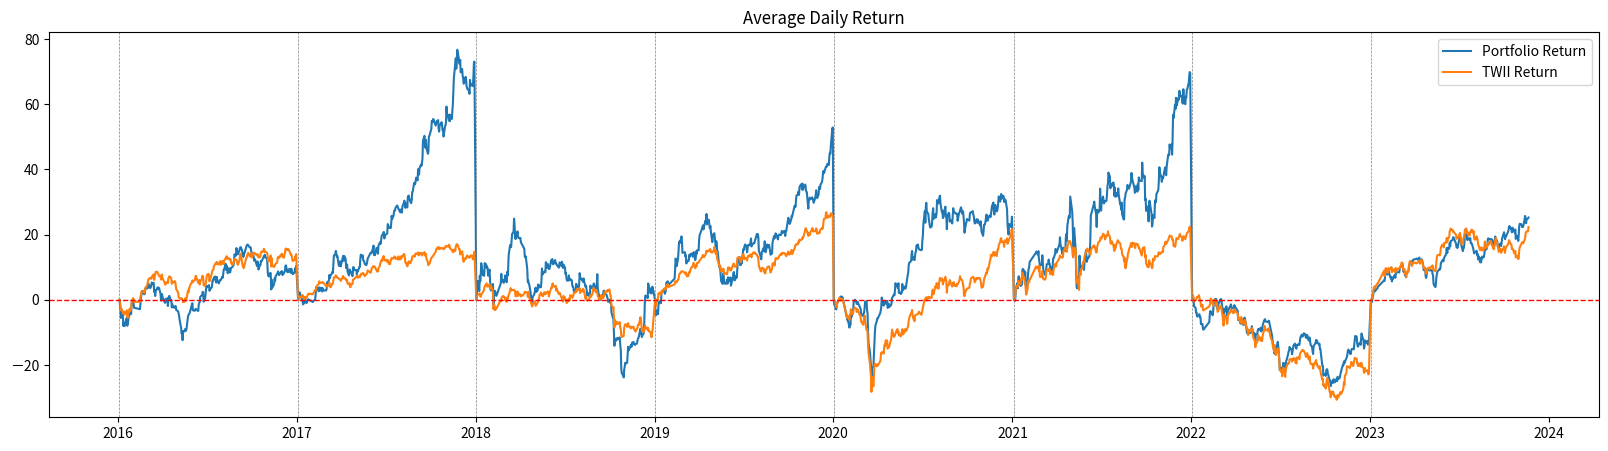

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

plt.figure(figsize=(20, 5))
plt.plot(total_return, label = 'Portfolio Return')
plt.plot(twii, label = 'TWII Return')
plt.axhline(y = 0, color = 'r', linestyle='--', linewidth = 1)
for date in start_date:
    plt.axvline(x = date, color = 'gray', linestyle='--', linewidth = 0.5)

plt.title("Average Daily Return")
plt.legend()
plt.show()